In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from concurrent.futures import ProcessPoolExecutor, as_completed

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v8_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v8_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

train_log = pd.read_csv('../train_log.csv')
test_log = pd.read_csv('../test_log.csv')

In [3]:
train_df

,session_id,yado_no,target,predict_no,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0,1,-1,0,1,-1,-1,0,0,205.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,212.0,364.0,40.0,3.0,1.0,1.0,4,6,8,11,335580,36215,13849,13529,881,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037868,0.036485
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0,2,-1,0,1,-1,-1,0,0,76.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,150.0,845.5,113.0,10.0,6.0,6.0,4,6,8,11,335580,36215,13849,13529,785,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041860,0.040170
2,000104bdffaaad1a1e0a9ebacf585f33,902,0,3,-1,0,1,-1,-1,0,0,240.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,154.0,785.5,103.0,9.0,5.0,5.0,4,6,8,11,335580,36215,13849,13529,675,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.041742,0.040073
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0,4,-1,0,1,-1,-1,0,0,111.0,1.0,0,1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,134.0,1114.0,143.0,16.0,12.0,12.0,4,6,8,11,335580,36215,13849,13529,671,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.032967,0.031939
4,000104bdffaaad1a1e0a9ebacf585f33,5490,0,5,-1,0,1,-1,-1,0,0,116.0,1.0,0,-1.0,-1.0,-1.0,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650,143.0,945.0,126.0,13.0,9.0,9.0,4,6,8,11,335580,36215,13849,13529,911,0,0.034651,0.033451,0.046152,0.044024,0.038851,0.037345,0.037307,0.035919,0.037037,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,0,5,-1,0,2,-1,-1,0,1,-1.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,50.0,4353.0,509.0,63.0,25.0,7.0,4,24,148,227,335580,38742,11787,2856,209,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.017964,0.017748
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,0,6,-1,0,2,-1,-1,0,0,198.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,138.0,1039.0,136.0,18.0,11.0,5.0,4,24,148,227,335580,38742,11787,2856,338,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.041722,0.039998,0.018450,0.018177
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,0,7,-1,0,2,-1,-1,0,0,94.0,1.0,1,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,840f2157ec5bb4f5501a3ace2f4ef8d1,120.0,1408.0,193.0,27.0,15.0,9.0,4,24,148,228,335580,38742,11787,8931,555,4,0.034665,0.033464,0.040508,0.038868,0.037076,0.035705,0.035605,0.034342,0.022624,0.022163
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,0,8,-1,0,2,-1,-1,0,0,310.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b0

In [4]:
print(train_df['seen_yad'].value_counts())
print(test_df['seen_yad'].value_counts())

0    2777527
Name: seen_yad, dtype: int64
0    1683604
Name: seen_yad, dtype: int64


### CatBoost Ranker

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import label_ranking_average_precision_score
from catboost import CatBoostRanker, Pool

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad', 'predict_no')]#, 'TE_wid_cd', 'TE_ken_cd', 'TE_lrg_cd', 'TE_sml_cd', 'TE_yado_no')] # seen_yadも入れる TEを抜かした方がいいか？
cat_cols = ['yado_no']+ ['label_wid_cd', 'label_ken_cd', 'label_lrg_cd', 'label_sml_cd'] 
target = 'target'  # ターゲット変数の列名
query_ids =  'session_id' #train_df['session_id'].values  # クエリIDの列名

# CatBoost のパラメータ
params = {
    'loss_function': 'YetiRank',  # YetiRankPairwise という選択肢もあります
    'learning_rate': 0.2,
    'iterations': 5000,
    'depth': 6,
    'random_seed': 42531,
    #"cat_features": cat_cols,
}

In [6]:
map_scores = []  # 各foldのMAPスコアを保存するリスト
test_pred = []   # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化

for fold in range(5):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # データセットの作成
    train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids])
    val_pool = Pool(data=valid_data[features], label=valid_data[target], group_id=valid_data[query_ids])

    # モデルの訓練
    model = CatBoostRanker(**params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=True)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(val_pool)
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存

    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    test_pred.append(model.predict(test_df[features]))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')


0:	test: 0.1671050	best: 0.1671050 (0)	total: 578ms	remaining: 48m 8s
1:	test: 0.1734773	best: 0.1734773 (1)	total: 1.04s	remaining: 43m 21s
2:	test: 0.1936255	best: 0.1936255 (2)	total: 1.54s	remaining: 42m 44s
3:	test: 0.2044465	best: 0.2044465 (3)	total: 2.05s	remaining: 42m 42s
4:	test: 0.2068513	best: 0.2068513 (4)	total: 2.53s	remaining: 42m 7s
5:	test: 0.2096495	best: 0.2096495 (5)	total: 3.01s	remaining: 41m 49s
6:	test: 0.2110986	best: 0.2110986 (6)	total: 3.52s	remaining: 41m 54s
7:	test: 0.2130204	best: 0.2130204 (7)	total: 3.97s	remaining: 41m 18s
8:	test: 0.2145339	best: 0.2145339 (8)	total: 4.44s	remaining: 41m
9:	test: 0.2164161	best: 0.2164161 (9)	total: 4.91s	remaining: 40m 52s
10:	test: 0.2171828	best: 0.2171828 (10)	total: 5.38s	remaining: 40m 40s
11:	test: 0.2181193	best: 0.2181193 (11)	total: 5.83s	remaining: 40m 21s
12:	test: 0.2185149	best: 0.2185149 (12)	total: 6.28s	remaining: 40m 10s
13:	test: 0.2189191	best: 0.2189191 (13)	total: 6.73s	remaining: 39m 56s
14:	

              Feature Id  Importances
0        TE_yado_no_mean     0.014858
1          count_yado_no     0.011652
2         TE_yado_no_var     0.011340
3             max_seq_no     0.008051
4                yado_no     0.005213
5         total_room_cnt     0.004467
6            ken_cd_rank     0.003555
7            sml_cd_rank     0.002914
8            wid_cd_rank     0.002719
9             popularity     0.002346
10          overall_rank     0.002190
11           lrg_cd_rank     0.002124
12          count_sml_cd     0.001474
13        TE_ken_cd_mean     0.001250
14        TE_sml_cd_mean     0.001144
15        TE_lrg_cd_mean     0.001066
16          label_sml_cd     0.001058
17          count_lrg_cd     0.000991
18          label_lrg_cd     0.000977
19             onsen_flg     0.000951
20        TE_wid_cd_mean     0.000812
21         TE_sml_cd_var     0.000675
22         TE_lrg_cd_var     0.000511
23          count_ken_cd     0.000497
24          label_ken_cd     0.000397
25          

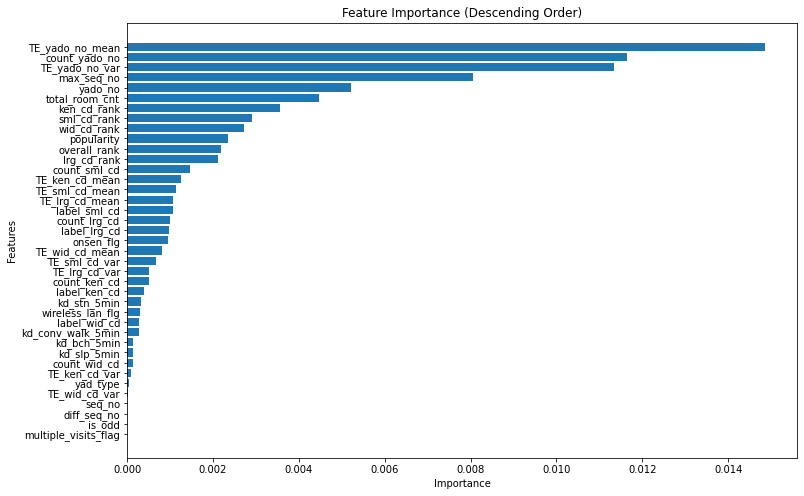

In [7]:
import matplotlib.pyplot as plt

# トレーニングデータセットでのPoolを作成（もしまだ作成していない場合）
#train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids])

# 特徴量の重要度を取得（トレーニングデータセットを使用）
feature_importances = model.get_feature_importance(train_pool, prettified=True)

# 特徴量の重要度を降順に並び替え
feature_importances.sort_values(by='Importances', ascending=False, inplace=True)

# 特徴量の重要度を表示
print(feature_importances)

# 特徴量の重要度をグラフで表示（降順）
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature Id'], feature_importances['Importances'])
plt.gca().invert_yaxis()  # y軸を逆順にして、重要度が高い特徴量を上に表示
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance (Descending Order)')
plt.show()



In [8]:
# train_dfのyado_noをyad_noに変更
train_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [9]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yad_no', 'oof_pred']].head()

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.516244
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0.095988
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.016845
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0.080698
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.862770


In [10]:
train_df[['session_id', 'yad_no', 'oof_pred']]

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.516244
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0.095988
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.016845
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0.080698
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.862770
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-3.418397
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-3.150558
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-2.994702
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-3.945702


In [11]:
oof_pred_df = train_df[['session_id', 'yad_no', 'oof_pred']]
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.516244
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0.095988
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.016845
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0.080698
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.862770
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-3.418397
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-3.150558
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-2.994702
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-3.945702


In [12]:
# アンサンブル用にoof_predを保存
oof_pred_df.to_csv('../ensemble/catRanker_ver2_oof_pred.csv', index=False)

In [13]:
oof_pred_df

,session_id,yad_no,oof_pred
0,000104bdffaaad1a1e0a9ebacf585f33,3894,0.516244
1,000104bdffaaad1a1e0a9ebacf585f33,7749,0.095988
2,000104bdffaaad1a1e0a9ebacf585f33,902,0.016845
3,000104bdffaaad1a1e0a9ebacf585f33,11380,0.080698
4,000104bdffaaad1a1e0a9ebacf585f33,5490,-0.862770
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-3.418397
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-3.150558
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-2.994702
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-3.945702


### CVの計算

In [14]:
train_log_df = pd.read_csv('../train_log.csv')
train_label_df = pd.read_csv('../train_label.csv')

In [15]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
oof_pred_df = oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
oof_pred_df.set_index('session_id', inplace=True)

In [16]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = '000104bdffaaad1a1e0a9ebacf585f33'
recommendations = get_top_recommendations(session_id_to_check, oof_pred_df)
print(recommendations)

[3894, 12491, 7749, 11380, 902, 1284, 4072, 254, 5490]
CPU times: user 158 ms, sys: 18 µs, total: 158 ms
Wall time: 157 ms


In [17]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = train_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = train_label_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(train_label_df))}
    for future in tqdm(as_completed(future_to_session), total=len(train_label_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 288698/288698 [00:45<00:00, 6331.92it/s]


In [18]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
result_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
result_df.columns = [f'predict_{i}' for i in range(result_df.shape[1])]
# 最初の列にセッションIDを追加する
# result_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
result_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,2808,997,12846,4101,11882,3324,5289,9208,9209,9207
1,8253,8225,4488,1586,8747,3725,2570,3564,11104,2259
2,1967,9039,13642,5238,7509,4355,4863,6722,2957,11724
3,13549,1341,109,755,626,11715,7872,7812,2272,13296
4,96,3894,12491,7749,11380,902,1284,4072,254,5490
...,...,...,...,...,...,...,...,...,...,...
288693,10955,13079,13210,3725,13717,10522,1586,8677,5719,2876
288694,963,4767,2900,8465,513,5299,6654,8703,399,3940
288695,7308,4040,10364,2087,844,3566,9558,7820,12240,4398
288696,10619,11091,7551,3238,570,10616,12781,12829,12500,11316


### 要素の集合にバグがないかを確認

In [19]:
candidate_ver15_train = pd.read_csv('../data/candidate_ver15_train.csv')

In [20]:
# 既存のDataFrameを読み込む
df1 = candidate_ver15_train
df2 = result_df#.drop(columns=['has_duplicates'])
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


### 順位変動のあったカラムを確認する

In [21]:
candidate_ver15_train

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...
288693,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [22]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_train != result_df

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_train[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(len(mismatched_rows))

一致していない行のインデックス：
0         True
1         True
2         True
3         True
4         True
          ... 
288693    True
288694    True
288695    True
288696    True
288697    True
Length: 288698, dtype: bool
一致していない行：
288682


In [23]:
candidate_ver15_train[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
5,10510,4823,12544,5369,1,9207,9199,9200,9201,9202
6,7531,441,2480,13240,10378,2282,7273,10442,12774,4574
7,4744,9508,7681,10362,12962,1755,12125,12464,111,10544
8,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
9,10478,379,550,3278,3483,6592,9773,9430,4303,2806


In [24]:
result_df[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,2808,997,12846,4101,11882,3324,5289,9208,9209,9207
1,8253,8225,4488,1586,8747,3725,2570,3564,11104,2259
2,1967,9039,13642,5238,7509,4355,4863,6722,2957,11724
3,13549,1341,109,755,626,11715,7872,7812,2272,13296
4,96,3894,12491,7749,11380,902,1284,4072,254,5490
5,4823,12544,10510,5369,9199,9207,9201,9202,9200,1
6,4574,12774,7531,2282,7273,2480,10378,441,10442,13240
7,111,10362,12464,4744,12962,9508,7681,1755,10544,12125
8,899,1227,3644,4014,3802,9723,12432,2164,13220,13702
9,3278,10478,6592,9773,550,379,3483,4303,2806,9430


In [25]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.values

In [26]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [27]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.4395162278657316


In [28]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
result_df['has_duplicates'] = result_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = result_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [29]:
# 欠損がないかをチェック
result_df.isnull().sum(axis=1).sum()

0

In [30]:
result_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,2808,997,12846,4101,11882,3324,5289,9208,9209,9207,False
1,8253,8225,4488,1586,8747,3725,2570,3564,11104,2259,False
2,1967,9039,13642,5238,7509,4355,4863,6722,2957,11724,False
3,13549,1341,109,755,626,11715,7872,7812,2272,13296,False
4,96,3894,12491,7749,11380,902,1284,4072,254,5490,False


### 推論用の候補テーブルを作成する

In [31]:
test_log_df = pd.read_csv('../test_log.csv')
test_session_df = pd.read_csv('../test_session.csv')

In [32]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[ 0.41412114 -0.63786659  1.04124614 ...  0.50324476  0.37619395
  0.41275917]
1683604


In [33]:
# test_predの形を調べる
print(np.array(test_pred).shape)

(5, 1683604)


In [34]:
# test_dfのyado_noをyad_noに変更
test_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [35]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yad_no', 'target']].head()

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,0.414121
1,00001149e9c73985425197104712478c,4714,-0.637867
2,00001149e9c73985425197104712478c,2680,1.041246
3,00001149e9c73985425197104712478c,4420,-0.018812
4,00001149e9c73985425197104712478c,5466,0.342186


In [36]:
test_oof_pred_df = test_df[['session_id', 'yad_no', 'target']]
test_oof_pred_df

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,0.414121
1,00001149e9c73985425197104712478c,4714,-0.637867
2,00001149e9c73985425197104712478c,2680,1.041246
3,00001149e9c73985425197104712478c,4420,-0.018812
4,00001149e9c73985425197104712478c,5466,0.342186
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.482596
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.446457
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.503245
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.376194


In [37]:
# test_oof_pred_dfのカラム名を変更
test_oof_pred_df.rename(columns={'target': 'oof_pred'}, inplace=True)
test_oof_pred_df

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,0.414121
1,00001149e9c73985425197104712478c,4714,-0.637867
2,00001149e9c73985425197104712478c,2680,1.041246
3,00001149e9c73985425197104712478c,4420,-0.018812
4,00001149e9c73985425197104712478c,5466,0.342186
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.482596
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.446457
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.503245
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.376194


In [38]:
test_oof_pred_df

,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,0.414121
1,00001149e9c73985425197104712478c,4714,-0.637867
2,00001149e9c73985425197104712478c,2680,1.041246
3,00001149e9c73985425197104712478c,4420,-0.018812
4,00001149e9c73985425197104712478c,5466,0.342186
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.482596
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.446457
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,0.503245
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.376194


In [39]:
# アンサンブル用にoof_predを保存
test_oof_pred_df.to_csv('../ensemble/catRanker_ver2_test_pred.csv', index=False)

In [40]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
test_oof_pred_df = test_oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
test_oof_pred_df.set_index('session_id', inplace=True)

In [41]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = 'ffffe984aafd6127ce8e43e3ca40c79d'
recommendations = get_top_recommendations(session_id_to_check, test_oof_pred_df)
print(recommendations)

[11723, 10729, 12767, 1891, 11994, 5623, 3781, 12620, 867, 634]
CPU times: user 91.3 ms, sys: 4.02 ms, total: 95.3 ms
Wall time: 97.1 ms


In [42]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = test_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = test_session_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=test_oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(test_session_df))}
    for future in tqdm(as_completed(future_to_session), total=len(test_session_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 174700/174700 [00:26<00:00, 6580.14it/s]


In [43]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
test_expanded_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
test_expanded_df.columns = [f'predict_{i}' for i in range(test_expanded_df.shape[1])]
# 最初の列にセッションIDを追加する
# expanded_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,9830,2680,11561,5466,4420,9534,6563,4714,5785
1,8108,7014,11923,6555,613,143,6129,4066,11237,12862
2,757,9190,410,9910,13570,6730,6721,1774,7710,10485
3,12341,3359,6991,10861,6489,13521,5080,10746,4180,1542
4,3476,12029,9623,10826,9020,3844,2862,3854,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,11123,7062,2278,5744,3440,10042,10997,9743
174696,899,3802,9723,1227,4014,13220,3644,12432,2164,13702
174697,12939,7308,13719,11796,11037,2087,13797,13241,8143,5810
174698,2373,2692,10287,3002,3100,4976,1687,5513,12281,13672


In [45]:
# 各行内で重複があるかどうかをチェック

def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
test_expanded_df['has_duplicates'] = test_expanded_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = test_expanded_df[test_expanded_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [46]:
# 欠損がないかをチェック
test_expanded_df.isnull().sum(axis=1).sum()

0

In [47]:
candidate_ver15_test = pd.read_csv('../data/candidate_ver15_test.csv')
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [48]:
# 行ごとに要素の集合が異なっていないかをチェック
import pandas as pd

# 既存のDataFrameを読み込む
df1 = candidate_ver15_test
df2 = test_expanded_df.drop('has_duplicates', axis=1)
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)

0


In [49]:
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [50]:
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,3560,9830,2680,11561,5466,4420,9534,6563,4714,5785,False
1,8108,7014,11923,6555,613,143,6129,4066,11237,12862,False
2,757,9190,410,9910,13570,6730,6721,1774,7710,10485,False
3,12341,3359,6991,10861,6489,13521,5080,10746,4180,1542,False
4,3476,12029,9623,10826,9020,3844,2862,3854,5372,6161,False
...,...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,11123,7062,2278,5744,3440,10042,10997,9743,False
174696,899,3802,9723,1227,4014,13220,3644,12432,2164,13702,False
174697,12939,7308,13719,11796,11037,2087,13797,13241,8143,5810,False
174698,2373,2692,10287,3002,3100,4976,1687,5513,12281,13672,False


In [51]:
test_expanded_df.drop(columns=['has_duplicates']).to_csv('../submissions/catRanker_ver2.csv', index=False)